# Demo for the data loader

In [1]:
# External packages
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import random

# Internal code import
import physo
import physo.learn.monitoring as monitoring
from physo.benchmark.utils import symbolic_utils as su
import sympy
from sympy import lambdify
import copy

Enforcing spawn multiprocessing start method.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.

Multiprocessing start method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs available :  96
Recommended config {'parallel_mode': False, 'n_cpus': 96}
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start metho

/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/physym/batch_execute.py:80: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
  warnings.warn(msg)
/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/physym/reward.py:252: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [2]:
DATA_PATH = '../Nbody/'

In [3]:
def list_folders(path):
    # List all entries in the directory given by path
    entries = os.listdir(path)
    # Filter out only directories
    folders = [entry for entry in entries if os.path.isdir(os.path.join(path, entry))]
    return [s for s in folders if '_' in s]

In [4]:
def load_data(model_name, myvars, simrange='mass_0.0-0.5', simtype='mass'):
    data = {}
    for name, filetag in myvars.items():
        data[name] = pd.read_csv(DATA_PATH + model_name + "/{}/{}_{}.dat".format(simtype,simrange,filetag), \
                                 delimiter=" ", header=None).to_numpy()
    data['age'] = pd.read_csv(DATA_PATH + model_name + "/age.dat", sep=r"\s+", header=None).to_numpy().flatten()
    
    return data

In [5]:
def select_slice(data, ref_age):
    idx = np.argmin(np.abs(data['age']-ref_age))
    myslice = copy.copy(data)
    for name in set(data.keys()) - set(['age']):
        myslice[name] = data[name][idx,:]
    myslice['age'] = ref_age
    return myslice

In [6]:
def dropna(data):
    selected_idx = ~np.isnan(data['mass'])
    for name in set(data.keys()) - set(['age']):
        data[name] = data[name][selected_idx]
    return data

In [7]:
def reduce(data, ref_var='mass', factor=100):
    selected_idx = range(0, len(data[ref_var]), factor)
    reduced = copy.copy(data)
    reduced['age'] = np.concatenate([np.full_like(data[ref_var][idx], data['age'][idx]) for idx in selected_idx])
    for name in set(data.keys()) - set(['age']):
        reduced[name] = data[name][selected_idx]
    return reduced

In [8]:
def target_vars(variables, ref_vars=['mass', 'age']):
    return list(set(variables)-set(ref_vars))

In [9]:
models = list_folders(DATA_PATH)
print(models)
selected_model = random.choice(models)

['250k_A_R2_10', '250k_A_R4_25_imf50', '250k_A_R4_25_retr', '250k_A_R4_25_lk', '250k_A_R2_25_vlk', '500k_C_R4_10', '250k_C_R2_10', '250k_C_R4_25', '250k_A_R4_25', '500k_A_R4_LC_part2', '250k_B_R4_25', '250k_C_R4_25_lk', '1.5M_A_R4_10', '250k_B_R4_25_lk', '250k_A_R2_25', '250k_C_R4_10', '250k_A_R2_5', '250k_A_R4_10', '250k_W6_R4_25_retr', '250k_W6_R4_25', '500k_A_R2_10', '250k_A_R4_10_retr', '250k_A_R4_25_vlk', '500k_A_R4_10', '500k_A_R4_LC_part1']


In [10]:
variables = {'mass': 'mass_bin', 'velocity': 'vphi', 'dispersion': 'disp_phi', 'radius': 'radial_bin'}
labels = {'mass': r"$mass$ [M\_\odot]", 'velocity': r"$v_\phi$ [km/s]", 'dispersion': r"$\sigma_\phi$ [km/s]", 'radius': 'r [km]'}
data = load_data(selected_model, variables)
print(data)
print(data.keys())

{'mass': array([[ 0.081,  0.084,  0.086, ...,  1.955,  2.927, 10.521],
       [ 0.081,  0.084,  0.086, ...,  1.968,  2.948,  9.303],
       [ 0.081,  0.084,  0.086, ...,  1.93 ,  2.853,  7.965],
       ...,
       [ 0.082,  0.085,  0.089, ...,    nan,    nan,    nan],
       [ 0.082,  0.085,  0.089, ...,    nan,    nan,    nan],
       [ 0.082,  0.085,  0.089, ...,    nan,    nan,    nan]],
      shape=(2211, 62)), 'velocity': array([[3.942, 3.87 , 3.618, ..., 3.619, 3.826, 3.714],
       [3.464, 3.647, 3.355, ..., 3.494, 3.56 , 3.608],
       [3.269, 3.364, 3.148, ..., 3.21 , 3.293, 3.418],
       ...,
       [0.798, 0.801, 0.918, ...,   nan,   nan,   nan],
       [0.827, 0.737, 0.921, ...,   nan,   nan,   nan],
       [0.815, 0.832, 0.834, ...,   nan,   nan,   nan]], shape=(2211, 62)), 'dispersion': array([[4.657, 4.656, 4.655, ..., 4.586, 4.496, 4.531],
       [4.449, 4.326, 4.45 , ..., 4.338, 4.369, 4.446],
       [4.238, 4.296, 4.274, ..., 4.295, 4.154, 4.037],
       ...,
       

{'mass': array([0.081, 0.084, 0.088, 0.091, 0.094, 0.097, 0.101, 0.105, 0.109,
       0.113, 0.117, 0.122, 0.127, 0.132, 0.137, 0.143, 0.149, 0.155,
       0.161, 0.168, 0.175, 0.183, 0.191, 0.199, 0.208, 0.217, 0.227,
       0.237, 0.248, 0.26 , 0.272, 0.284, 0.297, 0.311, 0.326, 0.342,
       0.358, 0.375, 0.393, 0.412, 0.433, 0.455, 0.477, 0.501, 0.526,
       0.555, 0.587, 0.622, 0.661, 0.681, 0.695, 0.712, 0.733, 0.758,
       0.796, 0.836, 0.874, 0.918, 0.961, 1.016, 2.116]), 'velocity': array([1.139, 1.135, 1.162, 1.262, 1.136, 1.199, 1.163, 1.184, 1.138,
       1.206, 1.199, 1.217, 1.193, 1.167, 1.144, 1.199, 1.214, 1.181,
       1.229, 1.208, 1.107, 1.297, 1.158, 1.102, 1.216, 1.187, 1.306,
       1.277, 1.183, 1.162, 1.286, 1.238, 1.304, 1.256, 1.287, 1.287,
       1.284, 1.151, 1.25 , 1.33 , 1.34 , 1.292, 1.285, 1.483, 1.322,
       1.353, 1.355, 1.347, 1.452, 1.433, 1.438, 1.411, 1.355, 1.514,
       1.528, 1.538, 1.452, 1.454, 1.539, 1.563, 1.445]), 'dispersion': array([2.

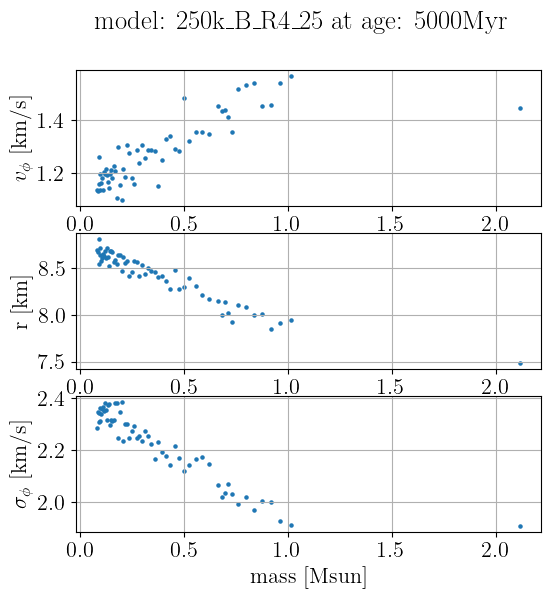

In [11]:
# Take a slice at given age

ref_age = 5000 # Myr
slice_at_age = select_slice(data, ref_age)
slice_at_age = dropna(slice_at_age)
print(slice_at_age)

fig, ax = plt.subplots(len(target_vars(data.keys())), 1, figsize=(6,6))
fig.suptitle("model: " + selected_model + " at age: " + str(ref_age) + "Myr")
for n,name in enumerate(target_vars(data.keys())):
    sc = ax[n].scatter(slice_at_age['mass'], slice_at_age[name], s=5)
    ax[n].set_xlabel("mass [Msun]")
    ax[n].set_ylabel(labels[name])
    ax[n].grid('on')
plt.show()

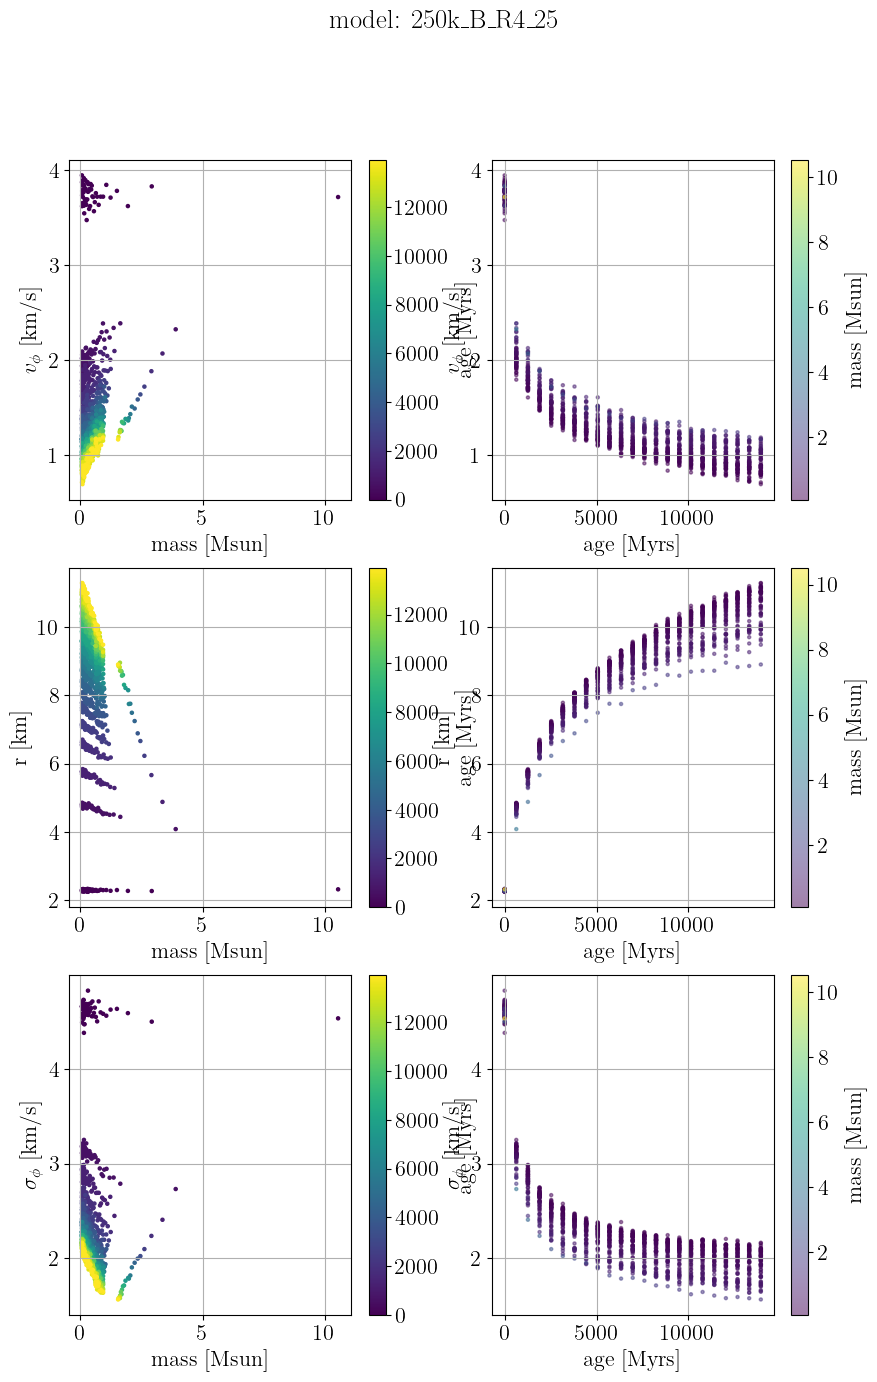

In [16]:
# Reduce data for plotting

reduced_data = reduce(data)
myvars = target_vars(data.keys())

fig, ax = plt.subplots(len(myvars), 2, figsize=(10,15))
fig.suptitle("model: " + selected_model)
for n,name in enumerate(myvars):
    sc = ax[n,0].scatter(reduced_data['mass'], reduced_data[name], c=reduced_data['age'], cmap='viridis', s=5)
    cbar = plt.colorbar(sc)
    cbar.set_label("age [Myrs]")
    ax[n,0].set_xlabel("mass [Msun]")
    ax[n,0].set_ylabel(labels[name])
    ax[n,0].grid('on')

    sc = ax[n,1].scatter(reduced_data['age'], reduced_data[name], c=reduced_data['mass'], alpha=0.5, cmap='viridis', s=5)
    cbar = plt.colorbar(sc)
    cbar.set_label("mass [Msun]")
    ax[n,1].set_xlabel("age [Myrs]")
    ax[n,1].set_ylabel(labels[name])
    ax[n,1].grid('on')

plt.show()